In [1]:
# Brightness is working good, corner point detection is challenging; fixing it in the next version

In [2]:
%matplotlib inline

import os
import math as mt
from sympy import Point, Line
from math import sin, cos, radians, pi
from scipy.signal import find_peaks
from sympy import Point, Line, Symbol, pi
from skimage import draw
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt
import time
from statistics import median, mode
import pandas as pd
from natsort import natsorted


import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import imutils
import sys
# sys.path.append('/media/recode/DATA2/Object_detector_test/')
# from barcode_detector_gray import BarcodeDetector

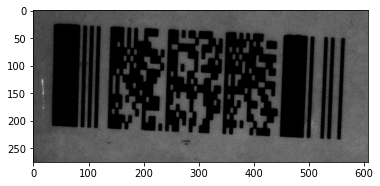

In [3]:
INPUT_CROP = '/media/Work/Codes/Private/pdf417-decoder/input/images/old_data/crop_image.png'
# INPUT_CROP = '/media/Work/Codes/Private/pdf417-decoder/input/images/crop_image_old.png'
# INPUT_CROP = '/media/Work/Codes/Private/pdf417-decoder/output/images/Method1/2_Crop/18_03_2021/11.00.00/18_03_2021_11.49.28.553_000/00045_1.bmp'
# INPUT_CROP = '/media/Work/Codes/Private/pdf417-decoder/output/images/Method1/2_Crop/18_03_2021/11.00.00/18_03_2021_11.57.09.766_000/00799_1.bmp'
INPUT_CROP = '/media/Work/Codes/Private/pdf417-decoder/input/images/old_data/1to90/1_75I.bmp'
INPUT_CROP = '/media/Work/Codes/Private/pdf417-decoder/input/images/old_data/1to90/1_90.bmp'
INPUT_CROP = '/media/Work/Codes/Private/pdf417-decoder/input/images/old_data/bright_chk/4E7EC3303FCE7827_72ff546e-750e-11eb-adef-c7ebaf55ade0_BD5.jpg'
crop_image = cv2.imread(INPUT_CROP, 0)
plt.imshow(crop_image, cmap='gray')

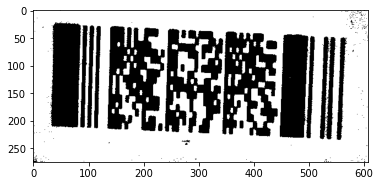

In [4]:
thresh1 = cv2.adaptiveThreshold(crop_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                          cv2.THRESH_BINARY, 199, 5)
plt.imshow(thresh1, cmap='gray')

167200


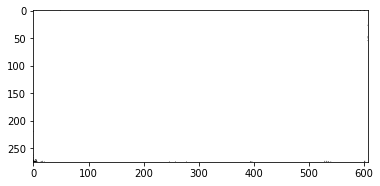

In [5]:
print(thresh1.shape[0] * thresh1.shape[1])
_, contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

immask = copy.deepcopy(thresh1)
c_max = max(contours, key = cv2.contourArea)
cv2.drawContours(immask,[c_max], 0, 255, -1)
    
plt.imshow(immask, cmap='gray')

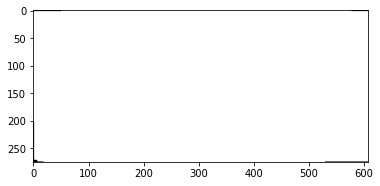

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(200,200))
opening = cv2.morphologyEx(immask, cv2.MORPH_OPEN, kernel)
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/open_image.bmp', opening)

plt.imshow(opening, cmap='gray')

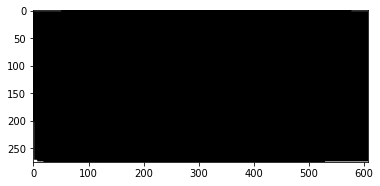

In [7]:
dest_not = cv2.bitwise_not(opening)
plt.imshow(dest_not, cmap='gray')

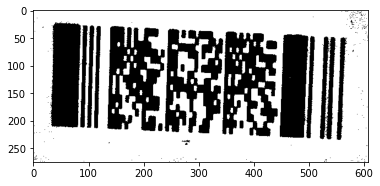

In [8]:
dest_and = cv2.bitwise_or(thresh1, dest_not, mask = None)
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/dest_image.bmp', dest_and)
plt.imshow(dest_and, cmap='gray')

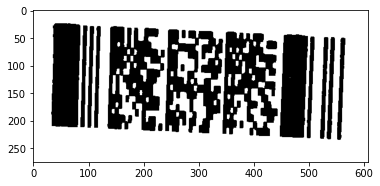

In [9]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
closing = cv2.morphologyEx(dest_and, cv2.MORPH_CLOSE, kernel)
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/close_image.bmp', closing)

plt.imshow(closing, cmap='gray')

In [10]:
kernel = np.ones((5,5),np.uint8)
new_mask = cv2.erode(opening,kernel,iterations = 6)

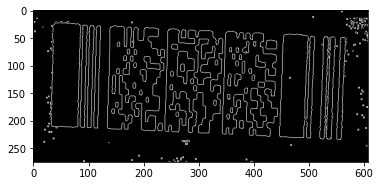

In [11]:
edge_image_dest_and = cv2.Canny(dest_and, 100, 200)
edge_image_dest_and = cv2.bitwise_and(edge_image_dest_and, new_mask)
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/edge_image_dest_and.bmp', edge_image_dest_and)
plt.imshow(edge_image_dest_and, cmap='gray')

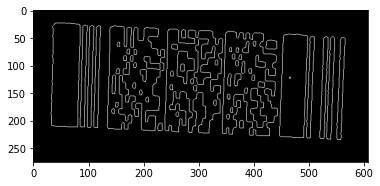

In [12]:
edge_image_closed = cv2.Canny(closing, 100, 200)
edge_image_closed = cv2.bitwise_and(edge_image_closed, new_mask)
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/edge_image_closed.bmp', edge_image_closed)
plt.imshow(edge_image_closed, cmap='gray')

In [13]:
l1 = Line((0, 0), (0, 10))

start = time.time()
lsd = cv2.createLineSegmentDetector(0)
dll = lsd.detect(edge_image_closed)
angless = []
distance_arr = []
x0_arr = []
y0_arr = []
x1_arr = []
y1_arr = []

if dll[0] is not None:
    for line in dll[0]:
        x0 = int(round(line[0][0]))
        y0 = int(round(line[0][1]))
        x1 = int(round(line[0][2]))
        y1 = int(round(line[0][3]))

        x0_arr.append(x0)
        y0_arr.append(y0)
        x1_arr.append(x1)
        y1_arr.append(y1)

        distance = mt.sqrt(((x1 - x0) ** 2) + ((y1 - y0) ** 2))
        distance_arr.append(distance)

print(f'Max Distance: {max(distance_arr)}')
max_distant_idx = distance_arr.index(max(distance_arr))
print(f'Max Distance ID: {max_distant_idx}')

max_x0 = x0_arr[max_distant_idx]
max_y0 = y0_arr[max_distant_idx]
max_x1 = x1_arr[max_distant_idx]
max_y1 = y1_arr[max_distant_idx]

angletan = mt.degrees(mt.atan2((max_y1 - max_y0),
                                         (max_x1 - max_x0)))

print(f'Angle1: {angletan}')

Max Distance: 183.17477992343814
Max Distance ID: 75
Angle1: -87.4968602204151


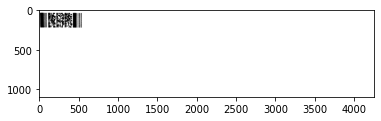

In [14]:
rows, cols = closing.shape

img_center = (rows, cols)
M = cv2.getRotationMatrix2D(img_center, 90 + angletan, 1)

rotated_image = cv2.warpAffine(closing, M, (7*cols, 4*rows), borderValue=(255,))
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/rotated_image.bmp', rotated_image)
plt.imshow(rotated_image, cmap='gray')

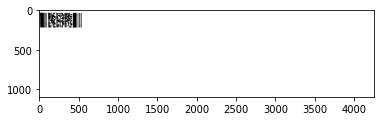

In [15]:
kernel = np.ones((1, 5), dtype=np.uint8)
vertical = cv2.morphologyEx(rotated_image, cv2.MORPH_CLOSE, kernel)
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/binary_vertical.bmp', vertical)
plt.imshow(vertical, cmap='gray')

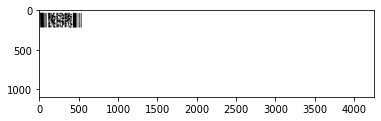

In [16]:
kernel = np.ones((9, 1), dtype=np.uint8)
horiz = cv2.morphologyEx(vertical, cv2.MORPH_CLOSE, kernel)
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/binary_horiz.bmp', horiz)
plt.imshow(horiz, cmap='gray')

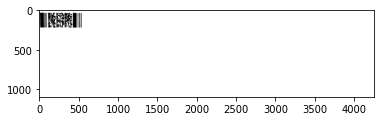

In [17]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))
opening1 = cv2.morphologyEx(horiz, cv2.MORPH_OPEN, kernel)

cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/opening.bmp', opening1)
plt.imshow(opening1, cmap='gray')

In [18]:
class GetBarcodeFeatures:
    @staticmethod
    def convert_image(var_image):
        d = np.ndim(var_image)

        if d == 3:
            var_gray_img = cv2.cvtColor(var_image, cv2.COLOR_BGR2GRAY)
        else:
            var_gray_img = var_image

        return var_gray_img
    
    @staticmethod
    def preprocess_image(image):
        thresh1 = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                                  cv2.THRESH_BINARY, 199, 5)

        _, contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        immask = copy.deepcopy(thresh1)
        c_max = max(contours, key = cv2.contourArea)
        cv2.drawContours(immask,[c_max], 0, 255, -1)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(200,200))
        opening = cv2.morphologyEx(immask, cv2.MORPH_OPEN, kernel)

        dest_not = cv2.bitwise_not(opening)
        dest_and = cv2.bitwise_or(thresh1, dest_not, mask = None)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
        closing = cv2.morphologyEx(dest_and, cv2.MORPH_CLOSE, kernel)

        kernel = np.ones((5,5),np.uint8)
        new_mask = cv2.erode(opening,kernel,iterations = 6)

        edge_image_closed = cv2.Canny(closing, 100, 200)
        edge_image_closed = cv2.bitwise_and(edge_image_closed, new_mask)

        start = time.time()
        lsd = cv2.createLineSegmentDetector(0)
        dll = lsd.detect(edge_image_closed)
        angless = []
        distance_arr = []

        x0_arr = []
        y0_arr = []
        x1_arr = []
        y1_arr = []

        if dll[0] is not None:
            for line in dll[0]:
                x0 = int(round(line[0][0]))
                y0 = int(round(line[0][1]))
                x1 = int(round(line[0][2]))
                y1 = int(round(line[0][3]))

                x0_arr.append(x0)
                y0_arr.append(y0)
                x1_arr.append(x1)
                y1_arr.append(y1)

                distance = mt.sqrt(((x1 - x0) ** 2) + ((y1 - y0) ** 2))
                distance_arr.append(distance)

        max_distant_idx = distance_arr.index(max(distance_arr))

        max_x0 = x0_arr[max_distant_idx]
        max_y0 = y0_arr[max_distant_idx]
        max_x1 = x1_arr[max_distant_idx]
        max_y1 = y1_arr[max_distant_idx]

        angletan = mt.degrees(mt.atan2((max_y1 - max_y0),
                                                 (max_x1 - max_x0)))
        rotation_angle = 90 + angletan
        rows, cols = closing.shape

        img_center = (rows, cols)
        M = cv2.getRotationMatrix2D(img_center, rotation_angle, 1)

        
        if cols <= rows:
            new_cols, new_rows = 7*cols, 4*rows
        else:
            new_cols, new_rows = 3*cols, 4*rows
            
        rotated_image = cv2.warpAffine(closing, M, (new_cols, new_rows), borderValue=(255,))

        kernel = np.ones((1, 5), dtype=np.uint8)
        vertical = cv2.morphologyEx(rotated_image, cv2.MORPH_CLOSE, kernel)

        kernel = np.ones((9, 1), dtype=np.uint8)
        horiz = cv2.morphologyEx(vertical, cv2.MORPH_CLOSE, kernel)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))
        preprocessed_image = cv2.morphologyEx(horiz, cv2.MORPH_OPEN, kernel)

        return preprocessed_image, rotation_angle

    @staticmethod
    def all_corners(var_gray_img, threshold=0.3):

        corners = cv2.goodFeaturesToTrack(var_gray_img, 1000, threshold, 10)
        var_all_corners = np.array(tuple(map(np.ravel, corners)), dtype=np.int0)
        var_all_corners.view('i8,i8').sort(order=['f1'], axis=0)

        return var_all_corners

    @staticmethod
    def image_corners(var_gray_img):
        '''Find corner indices of the Image'''

        row, col = var_gray_img.shape
        img_area = row * col
        var_image_corners = [[0, 0],
                             [col - 1, 0],
                             [col - 1, row - 1],
                             [0, row - 1]]

        return var_image_corners

    @staticmethod
    def min_dist(point, points_array):
        '''Find the min distance between reference points with the points'''

        x1, y1 = point
        dist_arr = []
        for i in range(len(points_array)):
            x2, y2 = points_array[i]
            d = mt.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            dist_arr.append(d)

        return min(dist_arr), np.argmin(dist_arr)

    @staticmethod
    def distances(var_all_corners, var_image_corners):
        '''Find the distances of corners of the Barcode'''

        var_distances = [GetBarcodeFeatures.min_dist(point, var_all_corners) for point in var_image_corners]

        return var_distances

    @staticmethod
    def order_points(points):
        rect = np.zeros((4, 2), dtype="float32")

        s = points.sum(axis=1)
        rect[0] = points[np.argmin(s)]
        rect[2] = points[np.argmax(s)]

        diff = np.diff(points, axis=1)
        rect[1] = points[np.argmin(diff)]
        rect[3] = points[np.argmax(diff)]

        return rect

    @staticmethod
    def barcode_corners(var_all_corners, var_distances):
        '''Get Barcode corner co-ordinates'''

        var_barcode_corners = GetBarcodeFeatures.order_points(np.array([var_all_corners[
                                                         var_distances[i][1]]
                                                     for i in range(4)]))
        return var_barcode_corners

    @staticmethod
    def find_top_border_angle(var_barcode_corners):
        '''Find Angle of Top border'''

        P1 = var_barcode_corners[0][:]
        P2 = var_barcode_corners[1][:]

        top_line_angle = 90 - round(mt.degrees(mt.atan2((round(P1[0], 2) -
                                                             round(P2[0], 2)),
                                                            (round(P1[1], 2) -
                                                             round(P2[1], 2)))))

        return top_line_angle

    @staticmethod
    def point_angles(var_barcode_corners):
        '''Get Barcode corner co-ordinates'''

        points = list(map(Point, var_barcode_corners))

        var_angle_arr = []
        for i in range(len(points)):
            l1 = Line(points[i], points[i - 1])
            try:
                l2 = Line(points[i], points[i + 1])
            except:
                l2 = Line(points[i], points[-len(points)])

            angle = l1.angle_between(l2)
            var_angle_arr.append(float(angle * (180 / pi)))

        return var_angle_arr

    @staticmethod
    def associated_pts(var_angle_arr):

        var_associat_pts = []
        angle_variance = []

        for i in range(len(var_angle_arr)):
            if i:
                angles = [var_angle_arr[i], var_angle_arr[i - 1]]
                var_associat_pts.append([i, angles])
            else:
                angles = [var_angle_arr[i], var_angle_arr[-1]]
                var_associat_pts.append([i, angles])
            angle_variance.append([i, np.var(angles)])

        return var_associat_pts, angle_variance

    @staticmethod
    def vert_dist(var_barcode_corners, var_all_corners):

        p1, p2 = var_barcode_corners[:2]
        ppcular_dist = []
        for i in range(len(var_all_corners)):
            p3 = var_all_corners[i]
            d = abs(np.cross(p2 - p1, p3 - p1) / np.linalg.norm(p2 - p1))
            ppcular_dist.append(d)
        var_vert_dist = np.array(ppcular_dist)

        return var_vert_dist
    
    @staticmethod
    def vert_dist2(var_all_corners):
        arr = [y for _, y in var_all_corners]
        return np.array(arr)

    @staticmethod
    def sorted_distances(var_vert_dist):
        var_sorted_dist = np.sort(var_vert_dist)

        return var_sorted_dist

    @staticmethod
    def distance_gradients(var_sorted_dist):
        var_dist_grad = np.gradient(var_sorted_dist)

        return var_dist_grad

    @staticmethod
    def highest_peak(distance_gradients):
        var_highest_peak = np.max(distance_gradients)

        return var_highest_peak

    @staticmethod
    def get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak, height=0.5):

        peak_indices, peaks = find_peaks(var_dist_grad, height=height * var_highest_peak)
        peak_indices = np.append(peak_indices, len(var_sorted_dist))

        var_peak_indices, var_peaks = peak_indices, peaks['peak_heights']

        return var_peak_indices, var_peaks

    @staticmethod
    def search_threshold(converted_image, in_threshold_arr=[0.25, 0.3, 0.35]):
        variance_data_arr = []
        peaks_data_arr = []
        out_threshold_arr = []

        present_flag = False

        for threshold in in_threshold_arr:

            try:
                # print(threshold_arr)
                print(threshold)
                var_all_corners = GetBarcodeFeatures.all_corners(converted_image, threshold=threshold)
                var_image_corners = GetBarcodeFeatures.image_corners(converted_image)
                var_distances = GetBarcodeFeatures.distances(var_all_corners, var_image_corners)
                var_barcode_corners = GetBarcodeFeatures.barcode_corners(var_all_corners, var_distances)
                top_line_angle = GetBarcodeFeatures.find_top_border_angle(var_barcode_corners)
                var_angle_arr = GetBarcodeFeatures.point_angles(var_barcode_corners)
                var_associat_pts, angle_variance = GetBarcodeFeatures.associated_pts(var_angle_arr)
                var_vert_dist = GetBarcodeFeatures.vert_dist(var_barcode_corners, var_all_corners)

                var_sorted_dist = GetBarcodeFeatures.sorted_distances(var_vert_dist)
                var_dist_grad = GetBarcodeFeatures.distance_gradients(var_sorted_dist)
                var_highest_peak = GetBarcodeFeatures.highest_peak(var_dist_grad)

                peak_indices, peaks = GetBarcodeFeatures.get_peaks(var_dist_grad,
                                                                   var_sorted_dist,
                                                                   var_highest_peak,
                                                                   height=0.5)
                variance_data = [np.var(peaks), np.var(np.gradient(peak_indices[:-1]))]
                print(f'threshold: {threshold}')
                print(f'peaks: {peak_indices}')
                print(f'len(peaks): {len(peaks)}')
                print(f'peaks_diff: {np.diff(np.array(sorted(peaks)))}')
                peaks_data_arr.append(peaks)
                variance_data_arr.append(variance_data)
                out_threshold_arr.append(threshold)
                present_flag = True

            except:
                pass

        if present_flag:
            variance_data_arr = np.transpose(variance_data_arr)
            peaks_data_arr = peaks_data_arr

        else:
            variance_data_arr = np.array([])
            peaks_data_arr = np.array([])

        return out_threshold_arr, peaks_data_arr, variance_data_arr

    @staticmethod
    def optim_threshold(threshold_arr, peaks_data, variance_data):
        var_optim_threshold = None
        save_var = {'variance': variance_data, 'peaks': peaks_data}

        good_heights = []
        if len(peaks_data):
            print(f'[max(peak) for peak in peaks_data]: {[max(peak) for peak in peaks_data]}')
            max_peak_list = [max(peak) for peak in peaks_data]

            sizes = []
            for max_peak, peaks_list in zip(max_peak_list, peaks_data):
                cap = 0.7 * max_peak

                print(f'max_peak: {max_peak}')
                print(f'peaks_list: {peaks_list}')
                mask = peaks_list >= cap
                size = len(peaks_list)
                sizes.append(size)

                print(f'mask: {mask}')
                print(f'size: {size}')

                good_height = np.count_nonzero(mask) == size
                print(f'good_height: {good_height}')

                good_heights.append(good_height)

            order = variance_data.argsort()
            ranks = order.argsort()
            total_variance = np.var(ranks, axis=0)
            weighted_ranks = np.sum(ranks, axis=0)
            cum_ranks = np.sum([total_variance, weighted_ranks], axis=0)
            print(f'variance_data: {variance_data}')
            print(f'total_variance: {total_variance}')
            print(f'cum_ranks: {cum_ranks}')

            index = np.argmin(cum_ranks)

            print(f'good_heights: {good_heights}')
            print(f'index: {index}')

            try:
                indices = [i for i, j in enumerate(sizes) if j == mode(sizes)]
            #       index = sizes.index(max(sizes))
                print(f'indices mode: {indices}')
            except:
                indices = [i for i, j in enumerate(sizes) if j == max(sizes)]

            good_indices = [index for index in indices if good_heights[index]]

            if len(good_indices):
                index = int(median(good_indices))
                var_optim_threshold = threshold_arr[index]

        print(f'var_optim_threshold: {var_optim_threshold}')
        return var_optim_threshold

    @staticmethod
    def class_centers(var_peak_indices, var_sorted_dist):
        '''To calculate centroids by averaging distance measures between peaks'''

        centroids = []
        for i in range(len(var_peak_indices)):
            if i == 0:
                min_idx = 0
                max_idx = var_peak_indices[i]
            elif i == len(var_peak_indices) - 1:
                min_idx = var_peak_indices[i - 1]
                max_idx = len(var_sorted_dist)
            else:
                min_idx = var_peak_indices[i - 1]
                max_idx = var_peak_indices[i]

            centroids.append(np.mean(var_sorted_dist[min_idx: max_idx]))

        return centroids

    @staticmethod
    def labels(var_vert_dist, var_sorted_dist, var_peak_indices):
        '''To get the labels of the co-ordinates with centroids as reference'''

        labels = copy.deepcopy(var_vert_dist)
        for i in range(len(var_peak_indices)):
            if i == 0:
                min_idx = 0
                max_idx = var_peak_indices[i]
            elif i == len(var_peak_indices) - 1:
                min_idx = var_peak_indices[i - 1]
                max_idx = len(var_sorted_dist) - 1
            else:
                min_idx = var_peak_indices[i - 1]
                max_idx = var_peak_indices[i]

            if i != len(var_peak_indices) - 1:
                labels[np.where((var_vert_dist < var_sorted_dist[max_idx]) &
                                (var_vert_dist >= var_sorted_dist[min_idx]))] = i
            else:
                labels[np.where((var_vert_dist <= var_sorted_dist[max_idx]) &
                                (var_vert_dist >= var_sorted_dist[min_idx]))] = i

        var_labels = labels.astype(int)

        return var_labels

    @staticmethod
    def center_coordinates(var_labels, var_all_corners):
        '''Find the centroid of the coordinates'''

        var_center_coord = []
        concur_feat_sep = []
        coords = var_all_corners

        for i in range(len(np.unique(var_labels))):
            selected_bin = coords[np.where(var_labels == i)]
            centroid = np.mean(selected_bin, axis=0)
            var_center_coord.append(centroid)
            concur_feat_sep.append(centroid.astype('int'))

        return var_center_coord, concur_feat_sep

    @staticmethod
    def concurrent_feature_sep(var_center_coord, var_barcode_corners):

        start = time.time()
        (p1, p2) = var_barcode_corners[:2]
        top_border = Line(Point(p1), Point(p2))
        mid_point = Point(p1).midpoint(Point(p2))
        ppcular_line = top_border.perpendicular_line(mid_point)
        tap1 = time.time()
        print(f'Time1: {tap1 - start}')
        a, b, c = ppcular_line.coefficients

        collect_feature_sep = []
        for centroid in var_center_coord:
            parallel_line = top_border.parallel_line(centroid)
            feature_sep = ppcular_line.intersection(parallel_line)
            collect_feature_sep.append(feature_sep[0])

        var_concur_feat_sep = collect_feature_sep
        print(f'Time2: {time.time() - tap1}')

        return var_concur_feat_sep

    @staticmethod
    def get_coord_dist(var_concur_feat_sep):
        dist_arr = []
        for p1, p2 in zip(var_concur_feat_sep, var_concur_feat_sep[1:]):
            dist_arr.append(p1.distance(p2))

        return dist_arr

    @staticmethod
    def overlay_corners(image, corners, radius, color, inplace=False):
        if not inplace:
            overlaid_image = copy.deepcopy(image)
        else:
            overlaid_image = image

        corners = tuple(map(tuple, corners))
        for corner in corners:
            cv2.circle(overlaid_image, corner, radius, color, -1)
        return overlaid_image

    @staticmethod
    def overlay_lines(image, start, end, line_thickness, line_color, inplace=False):
        if not inplace:
            overlaid_image = copy.deepcopy(image)
        else:
            overlaid_image = image

        start, end = tuple(map(tuple, start)), tuple(map(tuple, end))
        for start_line, end_line in zip(start, end):
            cv2.line(overlaid_image, start_line, end_line, line_color, line_thickness)

        return overlaid_image

    @staticmethod
    def line_count(int_var_center_coord, req_line_cnt):

        line_count = req_line_cnt
        (p1, p2) = int_var_center_coord[:2]
        (x, y), (s, t) = p1, p2
        d8 = max(abs(x - s), abs(y - t))
        #     print(f'd8: {d8}')

        if line_count > (d8 / 2.2):
            line_count = int(d8 / 2.2)
        else:
            line_count += 1

        #     print(f'line_count: {line_count}')
        var_norm_distance = 1 / line_count
        var_line_count = line_count - 1

        return var_line_count, var_norm_distance

    @staticmethod
    def line_prof(var_image_corners, var_center_coord, top_line_angle):
        line_prof_coor_arr = []
        y_borderpoints = var_image_corners[-1]
        x_borderpoints = var_image_corners[1]

        print(f'y_borderpoints: {y_borderpoints}')
        print(f'x_borderpoints: {x_borderpoints}')

        max_line_length = 20000

        x_angle = mt.cos(top_line_angle * pi / 180.0)
        y_angle = mt.sin(top_line_angle * pi / 180.0)

        print(f'x_angle: {x_angle}')
        print(f'y_angle: {y_angle}')

        for i in range(len(var_center_coord)):
            P1x, P1y = var_center_coord[i][0], var_center_coord[i][1]
            P1x = int(P1x)
            P1y = int(P1y)

            for j in range(max_line_length):
                P2x = int(round(P1x - j * x_angle))
                P2y = int(round(P1y - j * y_angle))

                if P2x in x_borderpoints or P2y in y_borderpoints:
                    break

            for j in range(max_line_length):
                P3x = int(round(P1x + j * x_angle))
                P3y = int(round(P1y + j * y_angle))

                if P3x in x_borderpoints or P3y in y_borderpoints:
                    break

                line_prof_coor_arr.append([(P3x, P3y), (P2x, P2y)])
        line_prof_coor_np_arr = np.asarray(line_prof_coor_arr)

        return line_prof_coor_np_arr

    @staticmethod
    def row_extraction(var_gray_img, var_image_corners, top_line_angle, var_center_coord, req_line_cnt=3):

        # start_t = time.time()
        Int_prof_points = []
        req_line_cnt = req_line_cnt / 2
        y_borderpoints = var_image_corners[-1]
        x_borderpoints = var_image_corners[1]
        max_line_length = 20000
        x_angle = mt.cos(top_line_angle * pi / 180.0)
        y_angle = mt.sin(top_line_angle * pi / 180.0)
        int_prof = []
        dup_check = []

        for i in range(len(var_center_coord) - 1):

            start = int(var_center_coord[i][1])
            end = int(var_center_coord[i + 1][1])

            length = (end - start) / 2
            need_row = np.arange(length - mt.floor(req_line_cnt), length + mt.ceil(req_line_cnt))
            data_arr = []

            for k in need_row:
                P1x, P1y = var_center_coord[i][0], var_center_coord[i][1] + k
                P1x = int(P1x)
                P1y = int(P1y)
                right_line_prof = []
                for j in range(max_line_length):
                    P2x = int(round(P1x - j * x_angle))
                    P2y = int(round(P1y - j * y_angle))
                    if P2x in x_borderpoints or P2y in y_borderpoints:
                        break
                    if len(right_line_prof) >= 1:
                        if [P2y, P2x] != dup_check[-1]:
                            right_line_prof.append(var_gray_img[P2y, P2x])
                    else:
                        right_line_prof.append(var_gray_img[P2y, P2x])
                    dup_check = [[P2y, P2x]]

                left_line_prof = []
                for j in range(max_line_length):
                    P3x = int(round(P1x + j * x_angle))
                    P3y = int(round(P1y + j * y_angle))
                    if P3x in x_borderpoints or P3y in y_borderpoints:
                        break
                    if len(left_line_prof) >= 1:
                        if [P3y, P3x] != dup_check[-1]:
                            left_line_prof.append(var_gray_img[P3y, P3x])
                    else:
                        left_line_prof.append(var_gray_img[P3y, P3x])
                    dup_check = [[P3y, P3x]]
                Int_prof_points.append([(P3x, P3y), (P2x, P2y)])
                left_line_prof.reverse()
                data = left_line_prof + right_line_prof
                data_arr.append(data)

            int_prof.extend(data_arr)

        # print('Int_profile_time : ',time.time()-start_t)
        Int_prof_points = np.asarray(Int_prof_points)

        return int_prof, Int_prof_points

    @staticmethod
    def debug_image(var_image,
                    var_all_corners,
                    var_barcode_corners,
                    concur_feat_sep,
                    Int_prof_points,
                    line_prof_coor_arr):

        debug_img = copy.deepcopy(var_image)

        if not debug_img.ndim == 3:
            debug_img = np.stack((debug_img,) * 3, axis=-1)

        pt1_thickness, pt1_color = 2, (255, 0, 0)
        pt2_thickness, pt2_color = 2, (0, 0, 255)
        pt3_thickness, pt3_color = 2, (0, 0, 255)
        l1_thickness, l1_color = 1, (0, 0, 255)
        l2_thickness, l2_color = 1, (0, 255, 0)

        left_coord_arr = Int_prof_points[:, 0]
        right_coord_arr = Int_prof_points[:, 1]
        debug_img = GetBarcodeFeatures.overlay_corners(debug_img, var_all_corners, pt1_thickness, pt1_color)
        debug_img = GetBarcodeFeatures.overlay_corners(debug_img, var_barcode_corners, pt2_thickness, pt2_color)
        debug_img = GetBarcodeFeatures.overlay_corners(debug_img, concur_feat_sep, pt3_thickness, pt3_color)
        debug_img = GetBarcodeFeatures.overlay_lines(debug_img, line_prof_coor_arr[:, 0], line_prof_coor_arr[:, 1],
                                  l1_thickness, l1_color)
        debug_img = GetBarcodeFeatures.overlay_lines(debug_img, left_coord_arr, right_coord_arr, l2_thickness, l2_color)

        return debug_img
    
    @staticmethod
    def debug_image_from_scratch(input_image, corner_threshold=0.2, height=0.5, req_line_cnt=3, 
                                 extra_pixels=5, var_threshold=5):
        var_gray_img = GetBarcodeFeatures.convert_image(input_image)
        preprocessed_image, rotation_angle = GetBarcodeFeatures.preprocess_image(var_gray_img)
        var_all_corners = GetBarcodeFeatures.all_corners(preprocessed_image, threshold=corner_threshold)
        var_image_corners = GetBarcodeFeatures.image_corners(preprocessed_image)
        var_distances = GetBarcodeFeatures.distances(var_all_corners, var_image_corners)
        var_barcode_corners = GetBarcodeFeatures.barcode_corners(var_all_corners, var_distances)
        top_line_angle = GetBarcodeFeatures.find_top_border_angle(var_barcode_corners)
        # var_angle_arr = GetBarcodeFeatures.point_angles(var_barcode_corners)
        # var_associat_pts, angle_variance = GetBarcodeFeatures.associated_pts(var_angle_arr)
        var_vert_dist = GetBarcodeFeatures.vert_dist(var_barcode_corners, var_all_corners)

        var_sorted_dist = GetBarcodeFeatures.sorted_distances(var_vert_dist)
        var_dist_grad = GetBarcodeFeatures.distance_gradients(var_sorted_dist)
        var_highest_peak = GetBarcodeFeatures.highest_peak(var_dist_grad)

        var_peak_indices, var_peaks = GetBarcodeFeatures.get_peaks(var_dist_grad,
                                                                   var_sorted_dist,
                                                                   var_highest_peak,
                                                                   height=height)
        centroids = GetBarcodeFeatures.class_centers(var_peak_indices, var_sorted_dist)
        var_labels = GetBarcodeFeatures.labels(var_vert_dist, var_sorted_dist, var_peak_indices)
        var_center_coord, int_var_center_coord = GetBarcodeFeatures.center_coordinates(var_labels, var_all_corners)
        var_concur_feat_sep = GetBarcodeFeatures.concurrent_feature_sep(var_center_coord, var_barcode_corners)
        line_prof_coord_arr = GetBarcodeFeatures.line_prof(var_image_corners, var_center_coord, top_line_angle)
        
        pixel_diffs = [1]
        if len(pixel_diffs):
            if all(np.array(pixel_diffs) <= var_threshold):
                thresholded = GetBarcodeFeatures.get_second_threshold(input_image, rotation_angle, 
                                                                      var_barcode_corners, extra_pixels)
                int_prof, Int_prof_points = GetBarcodeFeatures.row_extraction(thresholded,
                                                           var_image_corners,
                                                           top_line_angle,
                                                           var_center_coord, req_line_cnt)
        
                debug_image = GetBarcodeFeatures.debug_image(thresholded,
                                                     var_all_corners,
                                                     var_barcode_corners,
                                                     var_concur_feat_sep,
                                                     Int_prof_points,
                                                     line_prof_coord_arr)

                return debug_image
            else:
                raise Exception(f'pixel_diff: {pixel_diffs} > var_threshold: {var_threshold}')
        

    @staticmethod
    def plot_int_profile(var_int_prof_arr):

        fig_arr = []
        for i in range(len(var_int_prof_arr)):
            fig, ax = plt.subplots()
            for j in range(len(var_int_prof_arr[i])):
                elem_data = var_int_prof_arr[i][j]
                ax.plot(range(elem_data.shape[0]), elem_data, label='Line ' + str(j + 1))
            ax.legend()
            fig_arr.append(fig)

        return fig_arr

    @staticmethod
    def plot_gradient(var_dist_grad):
        '''Visualization of height of each step'''

        x = np.arange(len(var_dist_grad))
        y = var_dist_grad
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(x, y)
        plt.title('Peaks Graph')

        return fig
    
    @staticmethod
    def sharpen_peak(peak_idx_dist, peak_heights, peak_indices):        

        max_peak_height = max(peak_heights)
        max_peak_height_idx = peak_heights.index(max_peak_height)
        print(f'max_peak_height_idx: {max_peak_height_idx}')

        final_pivot_idx = max_peak_height_idx
        print(f'final_pivot_idx: {final_pivot_idx}, \
              peak_indices[max_peak_height_idx]: {peak_indices[final_pivot_idx]}')

        idx_range = [peak_indices[final_pivot_idx] - mt.floor((max_peak_idx_dist)/2),
                     peak_indices[final_pivot_idx] + mt.floor((max_peak_idx_dist)/2)]

        print(f'idx_range: {idx_range}')

        merge_indices = []
        merge_peak_indices = []
        merge_peaks = []

        for i, peak_idx in enumerate(peak_indices):
            if peak_idx in range(idx_range[0], idx_range[1]):
                merge_indices.append(i)
                merge_peak_indices.append(peak_idx)
                merge_peaks.append(peak_heights[i])

        print(f'merge_indices: {merge_indices}')
        print(f'merge_peak_indices: {merge_peak_indices}')
        print(f'merge_peaks: {merge_peaks}')

        if len(merge_peak_indices):

            new_idx = round(np.average(merge_peak_indices, weights=merge_peaks))
    #         new_idx = merge_peak_indices[np.argmax(merge_peaks)]
            new_peak = np.sum(merge_peaks)

            for index in sorted(merge_indices, reverse=True):
                print(f'deleted peak_idx_dist: {peak_idx_dist[index-1]}, peak_heights: {peak_heights[index]}')
                del peak_heights[index]
                del peak_indices[index]

        return new_peak, new_idx, peak_heights, peak_indices
    
    @staticmethod
    def peak_noise_eliminate(peak_heights, peak_indices):
    
        peak_heights = list(peak_heights)
        peak_indices = list(peak_indices)

        new_peak_indices = []
        new_peaks = []
        total_peaks = 0

        max_peak_idx_dist = max(peak_idx_dist)
        print(f'max_peak_idx_dist: {max_peak_idx_dist}')

        while True:
            if len(peak_heights):
                total_peaks += 1
                print(f'total_peaks: {total_peaks}')

                print(f'peak_heights: {peak_heights}')
                max_peak_height = max(peak_heights)
                max_peak_height_idx = peak_heights.index(max_peak_height)
                print(f'max_peak_height_idx: {max_peak_height_idx}')
                idx_of_max_peak_height = peak_indices[max_peak_height_idx]

                new_peak, new_idx, peak_heights, peak_indices = GetBarcodeFeatures.sharpen_peak(max_peak_idx_dist, 
                                                                                                peak_heights, 
                                                                                                peak_indices)

                new_peak_indices.append(new_idx)
                new_peaks.append(new_peak)

                if total_peaks >20:
                    raise Exception('Entered Infinite Loop')
                print(f'peak_heights: {peak_heights}')
                print(f'peak_indices: {peak_indices}')
                print(f'new_indices: {new_peak_indices}')
                print(f'new_peaks: {new_peaks}')

            else:
                break
        return new_peaks, new_peak_indices, total_peaks
    
    @staticmethod
    def get_second_threshold(image, rotation_angle, barcode_corners, extra_pixels):
        x_min, y_min = np.amin(barcode_corners, axis=0)
        x_max, y_max = np.amax(barcode_corners, axis=0)
                
        rows, cols = image.shape
        img_center = (rows, cols)
                
        M = cv2.getRotationMatrix2D(img_center, rotation_angle, 1)
        
        if cols <= rows:
            new_cols, new_rows = 7*cols, 4*rows
        else:
            new_cols, new_rows = 3*cols, 4*rows
            
        rotated_image = cv2.warpAffine(image, M, (new_cols, new_rows), borderMode=cv2.BORDER_TRANSPARENT)
        
        new_y_min = y_min - extra_pixels
        new_y_max = y_max + extra_pixels
        new_x_min = x_min - extra_pixels
        new_x_max = x_max + extra_pixels
        
        clamp = lambda n, min_n, max_n: max(min(max_n, n), min_n)
        
        correct_y_min = int(clamp(new_y_min, 0, new_rows - 2))
        correct_y_max = int(clamp(new_y_max, 0, new_rows - 1))
        correct_x_min = int(clamp(new_x_min, 0, new_cols - 2))
        correct_x_max = int(clamp(new_x_max, 0, new_cols - 1))
        
        crop_image = rotated_image[correct_y_min: correct_y_max, 
                                   correct_x_min: correct_x_max]
                
        thresholded = cv2.adaptiveThreshold(crop_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                            cv2.THRESH_BINARY, 199, 5)
        
        white_bkgd = np.full((new_rows, new_cols), 255, dtype=np.uint8)
        white_bkgd[correct_y_min: correct_y_max, 
                   correct_x_min: correct_x_max] = thresholded
        
        return white_bkgd

    @staticmethod
    def extract_rows_static_thres(input_image, corner_threshold, height=0.5, 
                                  req_line_cnt=3, extra_pixels=5, var_threshold=5):
        var_gray_img = GetBarcodeFeatures.convert_image(input_image)
        preprocessed_image, rotation_angle = GetBarcodeFeatures.preprocess_image(var_gray_img)
        var_all_corners = GetBarcodeFeatures.all_corners(preprocessed_image, threshold=corner_threshold)
        var_image_corners = GetBarcodeFeatures.image_corners(preprocessed_image)
        var_distances = GetBarcodeFeatures.distances(var_all_corners, var_image_corners)
        var_barcode_corners = GetBarcodeFeatures.barcode_corners(var_all_corners, var_distances)
        top_line_angle = GetBarcodeFeatures.find_top_border_angle(var_barcode_corners)
        # var_angle_arr = GetBarcodeFeatures.point_angles(var_barcode_corners)
        # var_associat_pts, angle_variance = GetBarcodeFeatures.associated_pts(var_angle_arr)
        var_vert_dist = GetBarcodeFeatures.vert_dist(var_barcode_corners, var_all_corners)

        var_sorted_dist = GetBarcodeFeatures.sorted_distances(var_vert_dist)
        var_dist_grad = GetBarcodeFeatures.distance_gradients(var_sorted_dist)
        var_highest_peak = GetBarcodeFeatures.highest_peak(var_dist_grad)

        var_peak_indices, var_peaks = GetBarcodeFeatures.get_peaks(var_dist_grad,
                                                                   var_sorted_dist,
                                                                   var_highest_peak,
                                                                   height=0.5)
        centroids = GetBarcodeFeatures.class_centers(var_peak_indices, var_sorted_dist)
        var_labels = GetBarcodeFeatures.labels(var_vert_dist, var_sorted_dist, var_peak_indices)
        var_center_coord, int_var_center_coord = GetBarcodeFeatures.center_coordinates(var_labels, var_all_corners)
#         var_concur_feat_sep = GetBarcodeFeatures.concurrent_feature_sep(var_center_coord, var_barcode_corners)
#         dist_arr = GetBarcodeFeatures.get_coord_dist(var_concur_feat_sep)
#         pixel_diffs = list(map(abs, np.diff(np.array(list(map(int, dist_arr))[1:]))))
#         print(f'pixel_diffs: {pixel_diffs}')
        pixel_diffs = [1]
        if len(pixel_diffs):
            if all(np.array(pixel_diffs) <= var_threshold):
                thresholded = GetBarcodeFeatures.get_second_threshold(input_image, rotation_angle, var_barcode_corners, extra_pixels)
                int_prof, Int_prof_points = GetBarcodeFeatures.row_extraction(thresholded,
                                                           var_image_corners,
                                                           top_line_angle,
                                                           var_center_coord, req_line_cnt)
                return int_prof, Int_prof_points, thresholded
            else:
                return [], [], np.array((1, 1))
        else:
            return [], [], np.array((1, 1))

        return None

    @staticmethod
    def extract_rows_dyn_thres(image, req_line_cnt,
                               threshold_arr=[0.2, 0.25, 0.3, 0.35],
                               var_threshold=5):
        var_gray_img = GetBarcodeFeatures.convert_image(image)

        threshold_arr, peaks_data_arr, variance_data_arr = GetBarcodeFeatures.search_threshold(var_gray_img, threshold_arr)
        var_optim_threshold = GetBarcodeFeatures.optim_threshold(threshold_arr, peaks_data_arr, variance_data_arr)

        if var_optim_threshold is not None:
            var_all_corners = GetBarcodeFeatures.all_corners(var_gray_img, threshold=var_optim_threshold)
            var_image_corners = GetBarcodeFeatures.image_corners(var_gray_img)
            var_distances = GetBarcodeFeatures.distances(var_all_corners, var_image_corners)
            var_barcode_corners = GetBarcodeFeatures.barcode_corners(var_all_corners, var_distances)
            top_line_angle = GetBarcodeFeatures.find_top_border_angle(var_barcode_corners)
            # var_angle_arr = GetBarcodeFeatures.point_angles(var_barcode_corners)
            # var_associat_pts, angle_variance = GetBarcodeFeatures.associated_pts(var_angle_arr)
            var_vert_dist = GetBarcodeFeatures.vert_dist(var_barcode_corners, var_all_corners)
            print(1)

            var_sorted_dist = GetBarcodeFeatures.sorted_distances(var_vert_dist)
            var_dist_grad = GetBarcodeFeatures.distance_gradients(var_sorted_dist)
            var_highest_peak = GetBarcodeFeatures.highest_peak(var_dist_grad)

            var_peak_indices, var_peaks = GetBarcodeFeatures.get_peaks(var_dist_grad, var_sorted_dist, var_highest_peak,
                                                                       height=0.5)
            centroids = GetBarcodeFeatures.class_centers(var_peak_indices, var_sorted_dist)
            var_labels = GetBarcodeFeatures.labels(var_vert_dist, var_sorted_dist, var_peak_indices)
            var_center_coord, int_var_center_coord = GetBarcodeFeatures.center_coordinates(var_labels, var_all_corners)
#             var_concur_feat_sep = GetBarcodeFeatures.concurrent_feature_sep(var_center_coord, var_barcode_corners)
#             dist_arr = GetBarcodeFeatures.get_coord_dist(var_concur_feat_sep)
#             pixel_diffs = list(map(abs, np.diff(np.array(sorted(list(map(int, dist_arr))[1:])))))
#             print(f'pixel_diffs: {pixel_diffs}')
            pixel_diffs = [1]
            if len(pixel_diffs):
                if all(np.array(pixel_diffs) <= var_threshold):
                    # var_line_count, var_norm_distance = GetBarcodeFeatures.line_count(int_var_center_coord, req_line_cnt)
                    # line_prof_coor_arr = GetBarcodeFeatures.line_prof(var_image_corners, var_center_coord, top_line_angle)                    
                    
                    int_prof, Int_prof_points = GetBarcodeFeatures.row_extraction(var_gray_img,
                                                                                  var_image_corners,
                                                                                  top_line_angle,
                                                                                  var_center_coord, req_line_cnt)
                    return int_prof, Int_prof_points
                else:
                    return [], []
            else:
                return [], []
        else:
            return [], []

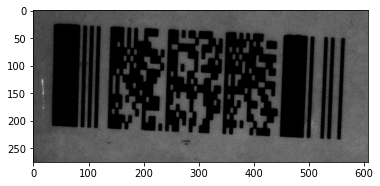

In [19]:
var_gray_img = GetBarcodeFeatures.convert_image(crop_image)
plt.imshow(var_gray_img, cmap='gray')

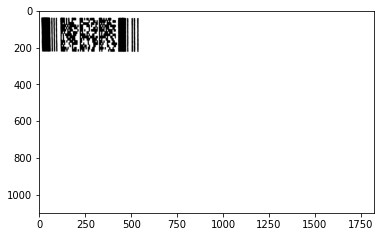

In [20]:
preprocessed_image, rotation_angle = GetBarcodeFeatures.preprocess_image(var_gray_img)
plt.imshow(preprocessed_image, cmap='gray')

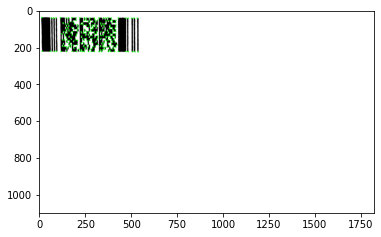

In [21]:
threshold = 0.2
var_all_corners = GetBarcodeFeatures.all_corners(preprocessed_image, threshold=threshold)
debug_img = cv2.merge((preprocessed_image, preprocessed_image, preprocessed_image))

pt1_thickness, pt1_color = 4, (0, 255, 0)
debug_img = GetBarcodeFeatures.overlay_corners(debug_img, var_all_corners, pt1_thickness, pt1_color)
plt.imshow(debug_img)

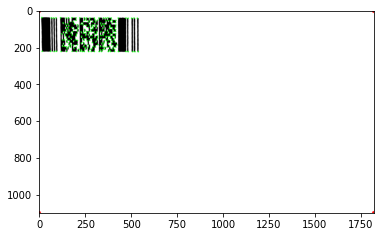

In [22]:
var_image_corners = GetBarcodeFeatures.image_corners(preprocessed_image)

pt2_thickness, pt2_color = 10, (255, 0, 0)
debug_img = GetBarcodeFeatures.overlay_corners(debug_img, var_image_corners, pt2_thickness, pt2_color)

plt.imshow(debug_img)

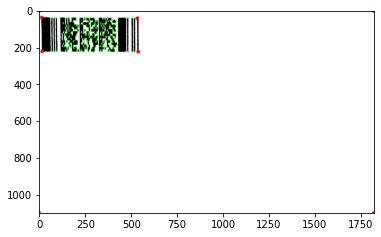

In [23]:
var_distances = GetBarcodeFeatures.distances(var_all_corners, var_image_corners)
var_barcode_corners = GetBarcodeFeatures.barcode_corners(var_all_corners, var_distances)

pt3_thickness, pt3_color = 10, (255, 0, 0)
debug_img = GetBarcodeFeatures.overlay_corners(debug_img, var_barcode_corners, pt3_thickness, pt3_color)
plt.imshow(debug_img)

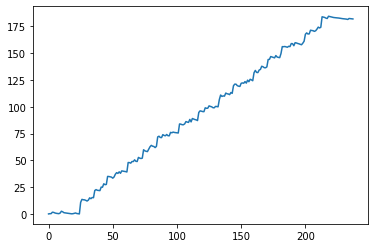

In [24]:
var_distances = GetBarcodeFeatures.distances(var_all_corners, var_image_corners)
var_barcode_corners = GetBarcodeFeatures.barcode_corners(var_all_corners, var_distances)
top_line_angle = GetBarcodeFeatures.find_top_border_angle(var_barcode_corners)
# var_angle_arr = GetBarcodeFeatures.point_angles(var_barcode_corners)
# var_associat_pts, angle_variance = GetBarcodeFeatures.associated_pts(var_angle_arr)
var_vert_dist = GetBarcodeFeatures.vert_dist(var_barcode_corners, var_all_corners)
plt.plot(var_vert_dist)
plt.show()

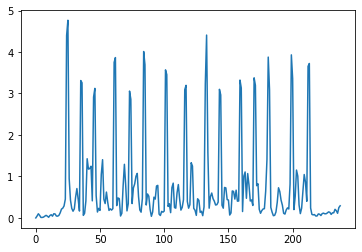

In [25]:
var_sorted_dist = GetBarcodeFeatures.sorted_distances(var_vert_dist)
var_dist_grad = GetBarcodeFeatures.distance_gradients(var_sorted_dist)
plt.plot(var_dist_grad)
plt.show()

In [26]:
var_highest_peak = GetBarcodeFeatures.highest_peak(var_dist_grad)

var_peak_indices, var_peaks = GetBarcodeFeatures.get_peaks(var_dist_grad,
                                                           var_sorted_dist,
                                                           var_highest_peak,
                                                           height=0.5)
var_peak_indices, var_peaks, len(var_peaks)

(array([ 25,  35,  46,  62,  73,  84, 101, 117, 133, 143, 159, 170, 181,
        199, 213, 238]),
 array([4.76524367, 3.31144051, 3.12298455, 3.86527029, 3.05760187,
        4.01141981, 3.5691252 , 3.19605931, 4.40756194, 3.09990831,
        3.32297863, 3.3768232 , 3.87680841, 3.93065297, 3.7229668 ]),
 15)

In [27]:
centroids = GetBarcodeFeatures.class_centers(var_peak_indices, var_sorted_dist)
var_labels = GetBarcodeFeatures.labels(var_vert_dist, var_sorted_dist, var_peak_indices)
var_center_coord, int_var_center_coord = GetBarcodeFeatures.center_coordinates(var_labels, var_all_corners)
var_center_coord

[array([284.56,  37.56]),
 array([318.7,  50.6]),
 array([282.45454545,  60.54545455]),
 array([278.6875,  74.25  ]),
 array([294.72727273,  86.72727273]),
 array([282.63636364,  97.27272727]),
 array([267.82352941, 110.23529412]),
 array([271.0625, 122.375 ]),
 array([292.625, 135.5  ]),
 array([299., 148.]),
 array([264.625 , 158.3125]),
 array([299.90909091, 171.        ]),
 array([258.81818182, 182.09090909]),
 array([270.05555556, 194.16666667]),
 array([292.14285714, 207.35714286]),
 array([290.92, 219.96])]

In [28]:
var_concur_feat_sep = GetBarcodeFeatures.concurrent_feature_sep(var_center_coord, var_barcode_corners)
dist_arr = GetBarcodeFeatures.get_coord_dist(var_concur_feat_sep)
pixel_diffs = list(map(abs, np.diff(np.array(list(map(int, dist_arr))[1:]))))
print(f'pixel_diffs: {pixel_diffs}')
# pixel_diffs = [1]

Time1: 0.011165142059326172
Time2: 0.9618208408355713
pixel_diffs: [3, 1, 2, 3, 1, 0, 0, 2, 2, 1, 0, 2, 1]


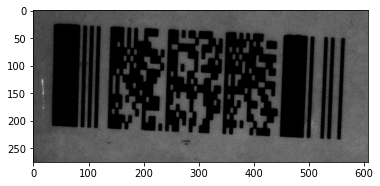

In [29]:
plt.imshow(crop_image, cmap='gray')

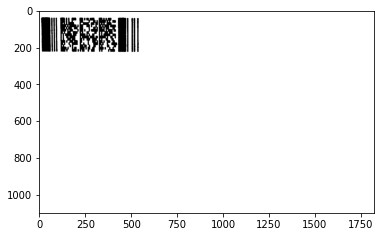

In [30]:
extra_pixels = 5
thresholded = GetBarcodeFeatures.get_second_threshold(crop_image, rotation_angle, var_barcode_corners, extra_pixels)
plt.imshow(thresholded, cmap='gray')

In [31]:
var_threshold = 5
req_line_cnt = 3

if len(pixel_diffs):
    if all(np.array(pixel_diffs) <= var_threshold):
        int_prof, Int_prof_points = GetBarcodeFeatures.row_extraction(thresholded,
                                                                    var_image_corners,
                                                                    top_line_angle,
                                                                    var_center_coord, 
                                                                    req_line_cnt)
print(f'len(int_prof): {len(int_prof)}')

len(int_prof): 45


In [32]:
line_prof_coord_arr = GetBarcodeFeatures.line_prof(var_image_corners, var_center_coord, top_line_angle)

y_borderpoints: [0, 1099]
x_borderpoints: [1823, 0]
x_angle: -1.0
y_angle: 1.2246467991473532e-16


Time1: 0.008919000625610352
Time2: 0.29270029067993164


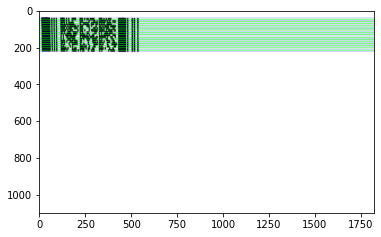

In [33]:
var_concur_feat_sep = GetBarcodeFeatures.concurrent_feature_sep(var_center_coord, var_barcode_corners)
debug_image = GetBarcodeFeatures.debug_image(thresholded,
                                             var_all_corners,
                                             var_barcode_corners,
                                             var_concur_feat_sep,
                                             Int_prof_points,
                                             line_prof_coord_arr)
plt.imshow(debug_image)

In [34]:
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/debug_image.bmp', debug_image)

True

In [35]:
debug_image = GetBarcodeFeatures.debug_image(preprocessed_image,
                                             var_all_corners,
                                             var_barcode_corners,
                                             var_concur_feat_sep,
                                             Int_prof_points,
                                             line_prof_coord_arr)
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/debug_image_old.bmp', debug_image)

True

In [36]:
test_image = np.abs(thresholded.astype(np.int32) - preprocessed_image.astype(np.int32))
test_image = test_image.astype(np.uint8)
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/test_image.bmp', test_image)

True

In [37]:
threshold = 0.2
new_int_prof, new_Int_prof_points, thresholded_new = GetBarcodeFeatures.extract_rows_static_thres(crop_image, threshold, req_line_cnt, extra_pixels=5, var_threshold=5)

In [38]:
debug_image = GetBarcodeFeatures.debug_image(thresholded_new,
                                             var_all_corners,
                                             var_barcode_corners,
                                             var_concur_feat_sep,
                                             new_Int_prof_points,
                                             line_prof_coord_arr)
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/debug_image_new.bmp', debug_image)

True

In [39]:
new_Int_prof_points.shape

(45, 2, 2)

In [40]:
test_arr = []

for x11, x12 in zip(int_prof, new_int_prof):
    for y11, y12 in zip(x11, x12):
        test_arr.append(y11 == y12)
all(test_arr)

True

In [41]:
np.sum(np.array(list(map(int, test_arr))))

82035

In [42]:
len(test_arr)

82035

In [43]:
test_image2 = np.abs(thresholded_new.astype(np.int32) - thresholded.astype(np.int32)).astype(np.uint8)
cv2.imwrite('/media/Work/Codes/Private/pdf417-decoder/output/images/test_image2.bmp', test_image2)

True

In [44]:
np.sum(test_image2)

0